In [ ]:
COLAB, KAGGLE = 1, 0
COLAB_LOADED = False
IS_DOWNLOADED = False
NGROK_IS_DOWNLOADED = False

In [ ]:
if not IS_DOWNLOADED:
    if COLAB:
        from google.colab import drive
        drive.mount('/content/drive')
    #!pip3 install tensorflow
    #!pip3 install tensorboard
    !pip3 install nmslib
    !pip3 install tensorboardx
    
    #!pip3 install gin-config==0.1.4
    #!wget ftp://171.64.64.64/cs/cvgl/Stanford_Online_Products.zip
    IS_DOWNLOADED = True
    

if not NGROK_IS_DOWNLOADED and KAGGLE:
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    !./ngrok authtoken 1c7d7L4ji4a6fzH7ajxpJcn5yhi_4WwPeiNEFFSG5MghJow7Q
    NGROK_IS_DOWNLOADED = True

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 13.0MB 70.0MB/s 
     |████████████████████████████████| 296kB 57.2MB/s 
     |████████████████████████████████| 204kB 9.4MB/s 


In [ ]:

import datetime, os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,BatchSampler
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import pickle
import cv2
from io import BytesIO
from PIL import Image
import zipfile
import gc
import math, os
from random import shuffle
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import nmslib 


In [ ]:
if 0:
    print("Reading zip file into memory...",end="")
    with open('Stanford_Online_Products.zip',"rb") as f:
        zip_file_in_mem = f.read()
    print("OK")
    file_like_object = BytesIO(zip_file_in_mem)
    sopzip = zipfile.ZipFile(file_like_object,"r")
else:
    sopzip = zipfile.ZipFile('Stanford_Online_Products.zip',"r")


In [ ]:
class ValidationDataset(Dataset):
    def __init__(self, root, query_and_retrieval_pickle, transform=None):
        """Imports dataset from folder structure.
        Args:
            root: (string) Folder where the image samples are kept.
            transform: (Object) Image processing transformations.
        Attributes: 
            classes: (list) List of the class names.
            class_to_idx: (dict) pairs of (class_name, class_index).
            samples: (list) List of (sample_path, class_index) tuples.
            targets: (list) class_index value for each image in dataset.
        """

        super(ValidationDataset, self).__init__()
        # ORIGINAL STRATEGY - Couldn't customize labels to include broader
        # folder structures.
        # self.data = datasets.ImageFolder(image_path, transform)

        self.transform = transform
        with open(query_and_retrieval_pickle, 'rb') as f:
            dataset = pickle.load(f)
            joined_paths = dataset['query'] + dataset['retrieval']
        self.query_count = len(dataset['query'])
        self.classes, self.class_to_idx = self._find_classes(joined_paths)
        self.samples = self.make_dataset(root, joined_paths, self.class_to_idx)
        self.targets = [s[1] for s in self.samples]

    def _find_classes(self, paths):
        """Creates classes from the folder structure.
        Args:
            dir: (string) Root directory path.
        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir),
            and class_to_idx is a dictionary.
        """

        classes = {}

        for path in paths:
            split = path.split('/')
            product_id = split[0]
            classes[product_id] = 0

        classes = sorted(list(classes.keys()))
        class_to_idx = {classes[i]: i for i in range(len(classes))}

        return classes, class_to_idx

    def make_dataset(self, dir, paths, class_to_idx):
        """Returns a list of image path, and target index
        Args:
            dir: (string) The path of each image sample
            class_to_idx: (dict: string, int) Sorted classes, mapped to int
        Returns:
            images: (list of tuples) Path and mapped class for each sample
        """

        images = []
        #7_261960396645/coffee_maker_final/coffee_maker_final_261960396645_2.JPG
        #Stanford_Online_Products/cabinet_final/121701014135_0.JPG
        for path in paths:
            split = path.split('/')
            product_id = split[0]
            item = (os.path.join(dir, split[1],split[2][len(split[1])+1:]), class_to_idx[product_id])
            #print(item[0])
            images.append(item)

        return images

    def get_class_dict(self):
        """Returns a dictionary of classes mapped to indicies."""
        return self.class_to_idx

    def __getitem__(self, index):
        """Returns tuple: (tensor, int) where target is class_index of
        target_class.
        Args:
            idx: (int) Index.
        """

        path, target = self.samples[index]
        #sample = default_loader(path)
        sample = zip_loader(path)
        sample = self.transform(sample)

        return sample, target, path

    def __len__(self):
        return len(self.samples)


def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

def zip_loader(path):
    filedata = sopzip.read(path)
    dataEnc = BytesIO(filedata)
    sample = Image.open(dataEnc).convert('RGB')
    dataEnc.close()
    return sample

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


# функция валидации, пример вызова смотри в конце файла
def validate_model(query_labels, query_embeddings, retrieval_labels, retrieval_embeddings):
    index = nmslib.init(method='hnsw', space='l2')
    index.addDataPointBatch(retrieval_embeddings)
    index.createIndex(print_progress=True)
    search_count = [1, 5, 10, 20]
    matches = np.zeros((len(search_count), len(query_labels)))
    for i in range(len(query_labels)):
        quary_label = query_labels[i]
        ids, distances = index.knnQuery(query_embeddings[i], k=max(search_count))
        local_retrieval_labels = retrieval_labels[ids]
        for j in range(len(search_count)):
            matches[j][i] = np.any(quary_label == local_retrieval_labels[:search_count[j]])
    res = []
    for i in range(len(search_count)):
        res.append(np.sum(matches[i]) / float(len(query_labels)))
        #print('Top', str(search_count[i]), '-', str(np.sum(matches[i]) / float(len(query_labels)) * 100.) + '%')
    return res




validation_query_and_retrieval_pickle = '/content/drive/My Drive/datasets/validation_dataset.pickle'
# Кастомный датасет, который считает картинки из пикла
# Путь до файла в пикле выглядит так:
# 2_151310032613/chair_final/chair_final_151310032613_0.JPG
# categoryId_productId/categoryName/categoryName_productId_imageNumber.JPG
# необходимо подстроить под свою структуру датасета пути в пикле и
# формирование путей до картинок в ValidationDataset (функции _find_classes и make_dataset)
# не забудь, что классы - это продукты, а не категории :)

data_valid_transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((123.68 / 255, 116.779 / 255, 103.939/ 255), (58.393 / 255, 57.12 / 255, 57.375/255)),
            #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ]
    )

proj_transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            #transforms.Resize(64),
            transforms.ToTensor()
        ]
    )
valid_dataset = ValidationDataset(root='Stanford_Online_Products',
                                     query_and_retrieval_pickle=validation_query_and_retrieval_pickle,
                                     transform=data_valid_transform)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64,
                                               shuffle=False, num_workers=1)

# чтобы картинки в Tensorboard Projector были адекватными
unnormalize = UnNormalize((123.68 / 255, 116.779 / 255, 103.939/ 255), (58.393 / 255, 57.12 / 255, 57.375/255))



In [ ]:
EMBADDING_SIZE = 128
resnet50 = torchvision.models.resnet50(pretrained=True)
#print(resnext50)

class ImageRetrievalResnet(nn.Module):
    def __init__(self, emb_size):
        super(ImageRetrievalResnet, self).__init__()
        resnet = torchvision.models.resnet50(pretrained=True)
        #fc = self.resnet.features.get_index_by_name('conv_1')
        self.bn_list = []
        self.weight_list = []
        self.deep_part = nn.Sequential(*[block for name,block in resnet.named_children() if name!='fc'] + [nn.Flatten()])
        for module in self.deep_part.modules():
          if isinstance(module, nn.BatchNorm2d):
            self.bn_list.append(module)
            module.weight.requires_grad_(requires_grad=False)
            module.bias.requires_grad_(requires_grad=False)
          if isinstance(module, nn.Conv2d):
            self.weight_list.append(module.weight)
        
        self.fc = nn.Linear(2048, emb_size, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        torch.nn.init.zeros_(self.fc.bias)
        #self.weight_list.append(self.fc.weight)
        #self.weight_list.append(self.fc.bias)

    def train(self, *args, **kwargs):
      self.deep_part.train()
      self.fc.train()
      for bn in self.bn_list:
        bn.eval()

    def eval(self, *args, ** kwargs):
      self.deep_part.eval()
      self.fc.eval()

    def forward(self, x):
        x = self.deep_part(x)
        x = self.fc(x)
        return F.normalize(x)

model = ImageRetrievalResnet(EMBADDING_SIZE)
print(f"model wd weights count = {len(model.weight_list)}")
CUDA = torch.cuda.device_count()
device = 'cuda'
#print(model)
#dummy = torch.ones((2, 3, 224, 224))
#print((model(dummy)**2).sum(dim=1))





Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



model wd weights count = 53


In [ ]:
VERYBIGNNUMBER = 100

n_mask = np.zeros((64,64))
n_mask[np.repeat(np.arange(64), 4),np.repeat(np.arange(64).reshape(-1,4),4, 0).reshape(-1)] = 1
p_mask = (n_mask + 1) % 2
p_mask[np.arange(64),np.arange(64)] = 1
p_mask = (p_mask + 1) % 2
n_mask = (n_mask + 1) % 2

def triplet_loss(batch, margin=1.0):
  distances = torch.norm(batch[:,None] - batch, dim=2, p=2)
  positive = distances[p_mask==1].reshape(-1,1) # 3 positive for each image, total size is 64*3
  negative = torch.repeat_interleave(distances[n_mask==1].reshape(64,60),3,dim=0) # duplicate negatives for each positive
  diff = positive - negative
  diff = diff[diff < 0] # exclude hardnegative
  diff = diff[diff > -margin] + margin # exclude easyhard
  return diff.sum() / diff.size(0), diff.size(0)

dummy = torch.rand(64, 128) - .5
print(triplet_loss(dummy))

(tensor(0.7623), 5859)


In [ ]:
SOP_DEFINITION = "/content/drive/My Drive/datasets/SOP_train_valid_split.pickle"
#{category_name: {'train': {'paths': [], 'product_labels': [], 'category_labels': []}, 'valid': ...}}

class SOP(Dataset):
    def __init__(self, _type='train', _transforms=None):
        assert _type in ['test', 'train', 'valid']

        self.transforms = _transforms
        self.samples = []
        self.labels = []
        with open(SOP_DEFINITION, 'rb') as f:
            sop_dict = pickle.load(f)
        self.classes_names = sop_dict.keys()
        self.class_labels_map = {key:sop_dict[key][_type]['category_labels'][0] for key in self.classes_names}
        self.class_products = {} # contains list indeces by ptod_label 
        self.class_product_labels = {} ## map class index to [prod_labels]
        self.dataset_len = 0
        for _class in self.classes_names:
          self.class_product_labels[self.class_labels_map[_class]] = []
          for ind, path in enumerate(sop_dict[_class][_type]['paths']):
            prod_label = sop_dict[_class][_type]['product_labels'][ind]
            if prod_label in self.class_products:
              self.class_product_labels[self.class_labels_map[_class]].append(prod_label)
              self.class_products[prod_label].append(self.dataset_len)
            else:
              self.class_products[prod_label] = [self.dataset_len]
            self.samples.append(path[1:])
            self.labels.append(sop_dict[_class][_type]['category_labels'][ind])
            self.dataset_len += 1

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, index):
        name = self.samples[index]
        filedata = sopzip.read(name)
        dataEnc = BytesIO(filedata)
        sample = Image.open(dataEnc).convert('RGB')
        dataEnc.close()
        if self.transforms:
            sample = self.transforms(sample)
        return sample, self.labels[index]


class TripletBatchSampler(BatchSampler):
    def __init__(self, dataset):
        self.prod_labels_to_indeces = dataset.class_products
        self.pl_by_class_label = dataset.class_product_labels
        self.dataset_size = dataset.dataset_len
        self.pl_to_index = {v:i for i,v in enumerate(self.prod_labels_to_indeces)}
        self.batch_size = 64
        self.class_count = 12


    def __iter__(self):
        self.count = 0
        for ind in self.pl_by_class_label:
          shuffle(self.pl_by_class_label[ind]) # shuffle labels in every class
        for pl in self.prod_labels_to_indeces:
          shuffle(self.prod_labels_to_indeces[pl])
        pl_curr_indices = np.zeros(self.class_count,dtype=np.int32)
        img_indices = np.zeros(len(self.prod_labels_to_indeces), dtype=np.int32)
        classes_order = np.arange(self.class_count) # 3 батча по 4 класса
        while self.count + self.batch_size < self.dataset_size:
            np.random.shuffle(classes_order)

            #3 batches
            for classes_index in range(0, self.class_count, 4):
              batch_indces = []
              for class_index in range(0,4):
                curr_class = classes_order[classes_index + class_index]
                pr_labels = self.pl_by_class_label[curr_class] # label list
                for pr_index in range(4):
                  prl_idx = (pl_curr_indices[curr_class] + pr_index) % len(pr_labels) # вдруг количество не кратно 4м
                  images = self.prod_labels_to_indeces[pr_labels[prl_idx]] #image_indices_list
                  im_beg_idx = img_indices[self.pl_to_index[pr_labels[prl_idx]]]
                  for i in range(4):
                    batch_indces.append(images[(im_beg_idx + i) % len(images)])
                  img_indices[self.pl_to_index[pr_labels[prl_idx]]] += 4
                pl_curr_indices[curr_class] += 4
              self.count += self.batch_size
              yield batch_indces

    def __len__(self):
        return self.dataset_size // self.batch_size



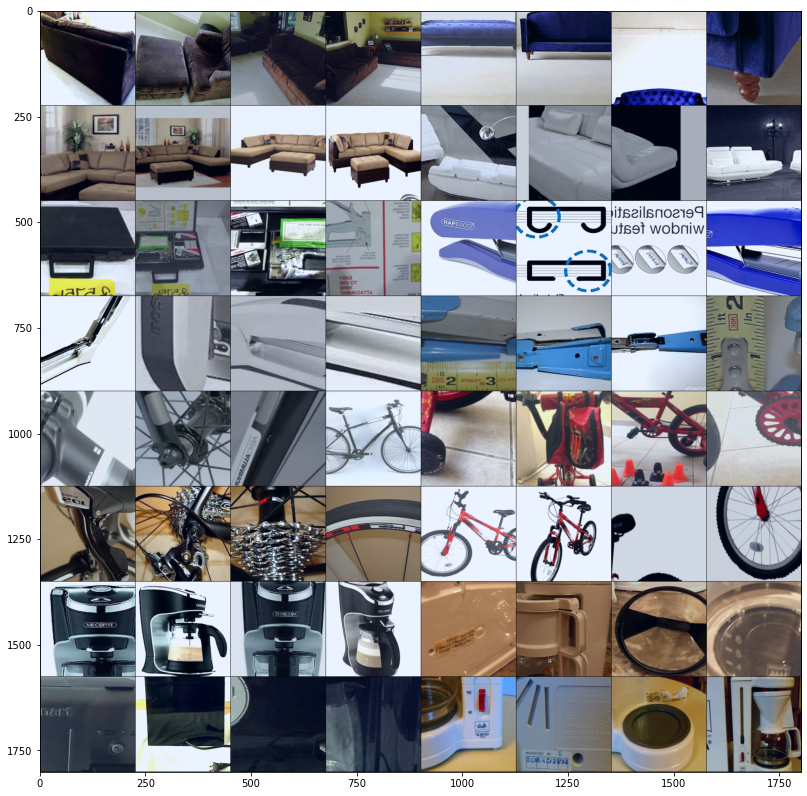

In [ ]:
train_transform = transforms.Compose(
        [
            transforms.RandomResizedCrop(224,scale=(0.15, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(saturation=0.3, contrast=0.3, brightness=0.3),
            transforms.ToTensor(),
            transforms.Normalize((123.68 / 255, 116.779 / 255, 103.939/ 255), (58.393 / 255, 57.12 / 255, 57.375 / 255)),
            #transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
        ]
    )
trainset = SOP('train', _transforms=train_transform)
def prin_batch():
    BS = 64
    TRAIN=1
    if TRAIN:
        test_loader = DataLoader(trainset, batch_sampler=TripletBatchSampler(trainset))
    else:
        test_loader = DataLoader(testset, batch_size=BS, shuffle=True)
    #train_loader = DataLoader(trainset, batch_size=BS, shuffle=True)
    
    epochs = 0
    epoch = 0
    images, labels = iter(test_loader).next()
    
    img = images.data 
    img = img - img.min()
    img = img / img.max()
    img = make_grid(img, nrow=8, padding=1).numpy()
    img = np.rollaxis(img, 0, 3)

    plt.figure(figsize=(14, 14)), plt.imshow(img), plt.show()
    if False:
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,0]), plt.show()
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,1]), plt.show()
        plt.figure(figsize=(14, 5)), plt.imshow(img[:,:,2]), plt.show()

prin_batch()

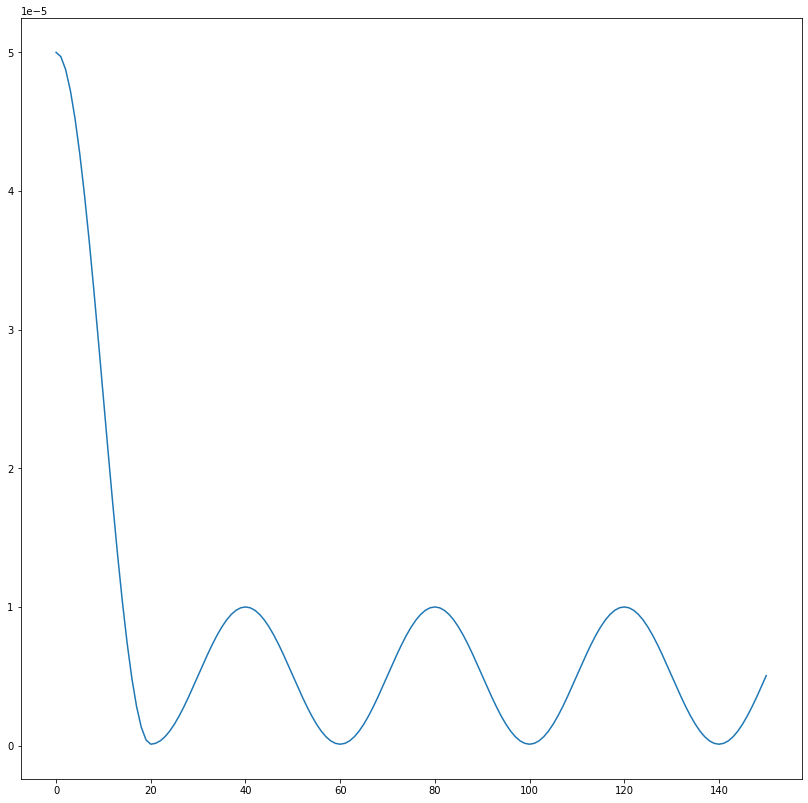

In [ ]:
#My linear cosine LR

class MyWarmupCosineAnnealingLR(torch.optim.lr_scheduler._LRScheduler):
    r"""
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        linear_lr_m (int): линейная часть
        T_max (int): Maximum number of iterations.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, linear_lr_m, T_max, eta_min=0, sin_max=0.01,last_epoch=-1):
        self.linear_lr_m = linear_lr_m
        self.T_max = T_max
        self.eta_min = eta_min
        self.sin_max = sin_max
        super(MyWarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        ''' копипаста cosine lr
        выдать список новых lr. base_lrs = [gr['init_lr'] for rg in opt.groups]'''
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)

        if self.last_epoch == 0:
            return [lr / self.linear_lr_m for lr in self.base_lrs] # initial lrs
        elif self.last_epoch <self.linear_lr_m:
            return [ (self.last_epoch + 1) * lr / self.linear_lr_m for lr in self.base_lrs]
        elif (self.last_epoch - self.linear_lr_m  - self.T_max) % (2 * self.T_max) == 0:
            return [group['lr'] + (self.sin_max - self.eta_min) *
                    (1 - math.cos(math.pi / self.T_max)) / 2
                    for base_lr, group in
                    zip(self.base_lrs, self.optimizer.param_groups)]
        return [(1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m +1) / self.T_max)) /
                (1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m ) / self.T_max)) *
                (group['lr'] - self.eta_min) + self.eta_min
                for group in self.optimizer.param_groups]

    def _get_closed_form_lr(self):
        return [self.eta_min + (base_lr - self.eta_min) *
                (1 + math.cos(math.pi * (self.last_epoch - self.linear_lr_m) / self.T_max)) / 2
                for base_lr in self.base_lrs]


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


BS = 64
LR = 0.00005#0.1 * BS / 256
WD = 8e-6
MOMENTUM = 0.9
LS_EPS = 0.1
linear_lr_m = 1 # количество эпох для линейного увеличения
T_max = 10 
eta_min = 0.0000001
SIN_MAX = 0.00001
MARGIN = 0.01

def test_lr():
  model = ImageRetrievalResnet(EMBADDING_SIZE)
  optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=0, nesterov=True)
  linear_lr_m = 1
  T_max = 20
  eta_min = 0.0000001
  SIN_MAX = 0.00001
  sched =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)
  lrs = [get_lr(optimizer)]
  optimizer.step()
  sched.step()
  for i in range(150):
      lrs.append(get_lr(optimizer)), optimizer.step(), sched.step()
  plt.figure(figsize=(14, 14))
  plt.plot(lrs)
  plt.show()

test_lr()

In [ ]:
#del model
#del batch
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi -q
#!bash


==============NVSMI LOG==============

Timestamp                           : Fri May 29 18:43:28 2020
Driver Version                      : 418.67
CUDA Version                        : 10.1

Attached GPUs                       : 1
GPU 00000000:00:04.0
    Product Name                    : Tesla P100-PCIE-16GB
    Product Brand                   : Tesla
    Display Mode                    : Enabled
    Display Active                  : Disabled
    Persistence Mode                : Disabled
    Accounting Mode                 : Disabled
    Accounting Mode Buffer Size     : 4000
    Driver Model
        Current                     : N/A
        Pending                     : N/A
    Serial Number                   : 0324317004125
    GPU UUID                        : GPU-29176f0d-2344-2341-f433-96537e067939
    Minor Number                    : 0
    VBIOS Version                   : 86.00.4D.00.01
    MultiGPU Board                  : No
    Board ID                        : 0x4
    GP

In [ ]:
import os
if not os.path.exists('ngrok'):
    !pip2 install google-auth-oauthlib==0.4.1 grpcio==1.24.3
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip
    !./ngrok authtoken 1c7d7L4ji4a6fzH7ajxpJcn5yhi_4WwPeiNEFFSG5MghJow7Q

get_ipython().system_raw('tensorboard --logdir "/content/drive/My Drive/datasets/runs_cv" --host 0.0.0.0 --port 1337 & ')
get_ipython().system_raw('./ngrok http 1337 &')
print("succes")

     |████████████████████████████████| 2.2MB 10.5MB/s 
ERROR: tensorflow 2.1.0 has requirement tensorflow-estimator<2.2.0,>=2.1.0rc0, but you'll have tensorflow-estimator 1.15.0 which is incompatible.
  Found existing installation: google-auth-oauthlib 0.4.0
    Uninstalling google-auth-oauthlib-0.4.0:
      Successfully uninstalled google-auth-oauthlib-0.4.0
  Found existing installation: grpcio 1.15.0
    Uninstalling grpcio-1.15.0:
      Successfully uninstalled grpcio-1.15.0
--2020-06-24 15:27:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.152.45.100, 52.21.2.64, 34.194.84.166, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.152.45.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  11.7MB/s    in 1.1s    

2020-06-24 15:27:49 (11.7 MB/s) -

In [ ]:
BS = 64
LR = 0.00005#0.1 * BS / 256
WD = 8e-6
MOMENTUM = 0.9
LS_EPS = 0.1
linear_lr_m = 1 # количество эпох для линейного увеличения
T_max = 20 
eta_min = 0.0000001
SIN_MAX = 0.00001
MARGIN = 0.05
INIT_VALIDATION = False
SAVE_MODEL = True
#71 exp 8 wd1e05 lr 0.00005 margin 0.25
EXP_NUM = 30
print(f"Begin experiment {EXP_NUM}")
PATH = "/content/drive/My Drive/models/resne50_embadings{}.pt".format(EXP_NUM)
EPOCH_START = 0
get_ipython().system_raw('tensorboard --logdir "/content/drive/My Drive/datasets/runs_cv" --host 0.0.0.0 --port 1337 & ')
get_ipython().system_raw('./ngrok http 1337 &')
#writer = SummaryWriter(logdir='./runs/{}'.format(datetime.datetime.now().strftime("%B_%d_%Y_%H_%M")))
writer = SummaryWriter(logdir='/content/drive/My Drive/datasets/runs_cv/image_retrieval{}'.format(EXP_NUM))
mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc = None, None, None, None, None
def train():
    global mean_train_losses, mean_test_losses, train_acc_list, test_acc_list, balanced_test_acc
    gc.collect()
    mean_train_losses = []
    mean_test_losses = []
    mean_triplet_count = []
    test_acc_list = []
    train_acc_list = []
    balanced_test_acc = []
    model = ImageRetrievalResnet(EMBADDING_SIZE)
    train_loader = DataLoader(trainset, batch_sampler=TripletBatchSampler(trainset))
    epochs = 100
    best_acc = 0
    # torch.save(model, PATH)
    # print(f"Model was dumped to {PATH}")

    #model = torch.load("/content/drive/My Drive/models/resne50_embadings3.pt")
    #model.eval()
    print("train started")
    if CUDA:
        device = 'cuda'
        gc.collect()
        torch.cuda.empty_cache()
        model.to(device)
    #optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WD, nesterov=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True) 
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4, factor=0.1 )
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,10,15,32], gamma=0.1)
    scheduler =  MyWarmupCosineAnnealingLR(optimizer,linear_lr_m, T_max, eta_min=eta_min, sin_max=SIN_MAX, last_epoch=-1)
    if INIT_VALIDATION:
      with torch.no_grad():

            images = []
            labels = []
            embeddings = []
            iter_count = len(valid_loader)
            for i, data in enumerate(valid_loader):
                print(f"\r\tvalidating {i}/{iter_count}...", end='')

                inputs_batch, labels_batch, paths = data
                
                if CUDA:
                    inputs_batch = inputs_batch.to(device)
                    
                #inputs_batch = torch.autograd.Variable(inputs_batch).to(device)
                outputs = model(inputs_batch)
                #outputs = F.normalize(outputs, p=2, dim=1)
                for i in range(len(inputs_batch)):
                    images.append(paths[i])
                    labels.append(labels_batch[i])
                    embeddings.append(outputs[i].cpu().detach().numpy())

            images = np.array(images)
            embeddings = np.array(embeddings)
            labels = np.array(labels)
            
            query_labels = labels[:valid_dataset.query_count]
            query_embeddings = embeddings[:valid_dataset.query_count]
            retrieval_labels = labels[valid_dataset.query_count:]
            retrieval_embeddings = embeddings[valid_dataset.query_count:]
            valid_res = validate_model(query_labels, query_embeddings, retrieval_labels, retrieval_embeddings)

      print(valid_res)

    for epoch in range(epochs):
        print(f"epoch : {epoch}")
        epoch_start_time = time.time()
        model.train()

        train_losses = []
        train_triplet_count = []

        iter_count = len(train_loader)
        for i, data in enumerate(train_loader):
            epoch += EPOCH_START
            images, label_batch = data
            #print(model.bn_list[3].bias)
            if CUDA:
                images = images.to(device)


            optimizer.zero_grad()

            outputs = model(images)

            #_, predicted = torch.max(outputs.data, 1)

            #np.add.at(correct, label_batch[(predicted == labels)], 1)
            #np.add.at(total,label_batch,1)

            #loss = loss_fn(outputs, labels)
            #loss = smooth_loss(outputs, labels, eps=LS_EPS)
            loss, triplet_count = triplet_loss(outputs, margin=MARGIN)

            writer.add_scalar("TRAIN (BATCH)/loss",loss.item(), epoch*iter_count + i)

            reg_loss = (model.fc.weight ** 2).sum()
            reg_loss += (model.fc.bias ** 2).sum()
            for param in model.weight_list:
                reg_loss += (param ** 2).sum() 
            reg_loss = WD*reg_loss
            loss = loss + reg_loss
            
            
            
            loss.backward()
            optimizer.step()
            

            train_losses.append(loss.item())
            train_triplet_count.append(triplet_count)
            
            writer.add_scalar("TRAIN (BATCH)/reg_loss",reg_loss.item(), epoch*iter_count + i)
            writer.add_scalar("TRAIN (BATCH)/full_loss",loss.item(), epoch*iter_count + i)
            writer.add_scalar("TRAIN (BATCH)/triplets_count", triplet_count, epoch*iter_count + i)
            
            print(f"\r\ttraining {i}/{iter_count} | loss: {train_losses[-1]} | triplet_count: {triplet_count}", end="") #reg_loss{reg_loss.item()}
        
        print()
        
        with torch.no_grad():

          images = []
          labels = []
          embeddings = []
          iter_count = len(valid_loader)
          for i, data in enumerate(valid_loader):
              print(f"\r\tvalidating {i}/{iter_count}...", end='')

              inputs_batch, labels_batch, paths = data
              
              if CUDA:
                  inputs_batch = inputs_batch.to(device)
                   
              #inputs_batch = torch.autograd.Variable(inputs_batch).to(device)
              outputs = model(inputs_batch)
              #outputs = F.normalize(outputs, p=2, dim=1)
              for i in range(len(inputs_batch)):
                  images.append(paths[i])
                  labels.append(labels_batch[i])
                  embeddings.append(outputs[i].cpu().detach().numpy())

          images = np.array(images)
          embeddings = np.array(embeddings)
          labels = np.array(labels)

          if False:
            # добавляем 1000 случайных эмбедингов для визуализации в Tensorboard Projector
            # обязательно реализовать у себя визуализацию эмбедингов, так как я помогаю
            # с реализацией, то за невыполнение будет снижаться балл!
            #writer = SummaryWriter(logdir='/content/drive/My Drive/datasets/runs/projector') # можно писать и в ту же папку логов, что и при обучении
            random_indices = np.arange(len(embeddings))
            np.random.shuffle(random_indices)
            random_indices = random_indices[:1000]
            projector_embeddings = embeddings[random_indices]
            projector_images = []
            to_tensor = transforms.ToTensor()
            for path in images[random_indices]:
              projector_images.append(proj_transform(zip_loader(path)).numpy())
            projector_images = np.stack(projector_images)
            projector_class_labels = [valid_dataset.classes[label] for label in labels[random_indices]]
            writer.add_embedding(projector_embeddings,
                                metadata=projector_class_labels,
                                label_img=projector_images, global_step=epoch)

          # первые query_count элементов датасета - query картинки, остальные retrieval set
          query_labels = labels[:valid_dataset.query_count]
          query_embeddings = embeddings[:valid_dataset.query_count]
          retrieval_labels = labels[valid_dataset.query_count:]
          retrieval_embeddings = embeddings[valid_dataset.query_count:]
          valid_res = validate_model(query_labels, query_embeddings, retrieval_labels, retrieval_embeddings)
          print(valid_res)


        mean_train_losses.append(np.mean(train_losses))
        mean_triplet_count.append(np.mean(train_triplet_count))

        #scheduler.step(mean_train_losses[-1])
        
        writer.add_scalars('Total/Loss', {'train': mean_train_losses[-1]}, epoch)
        writer.add_scalar('Total/LR', get_lr(optimizer), epoch)
        writer.add_scalar('Total/Mean_triplet_count', mean_triplet_count[-1], epoch)
        writer.add_scalars('Total/acc', {f"top-{top}": _acc for top, _acc in zip([1, 5, 10, 20], valid_res)}, epoch)
            
        if SAVE_MODEL and valid_res[0] > best_acc:
            torch.save(model, PATH+".pt") # {balanced_test_acc[-1]}
            best_acc =valid_res[0]
            print(f"Model was dumped to {PATH}")
        scheduler.step()
        print('\n\ttrain loss : {}, best-top1acc: {} epoch_time: {}s' \
              .format( mean_train_losses[-1], np.round(best_acc, 5), int(time.time()-epoch_start_time)))

if __name__=="__main__":
  try:
      train()
  except Exception as e:
      print(f"ERROR: {e}")


Begin experiment 30
train started
epoch : 0
	training 1124/1124 | loss: 0.07430320233106613 | triplet_count: 184
	validating 375/376...[0.6572492334647394, 0.7590889180902322, 0.7956636005256241, 0.8296101620674551]


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ImageRetrievalResnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Model was dumped to /content/drive/My Drive/models/resne50_embadings30.pt

	train loss : 0.07332533479399152, best-top1acc: 0.65725 epoch_time: 1059s
epoch : 1
	training 1124/1124 | loss: 0.07520151138305664 | triplet_count: 125
	validating 375/376...[0.6736749890494963, 0.7757336837494525, 0.8116513359614542, 0.8407796758650898]
Model was dumped to /content/drive/My Drive/models/resne50_embadings30.pt

	train loss : 0.0732045896185769, best-top1acc: 0.67367 epoch_time: 1013s
epoch : 2
	training 416/1124 | loss: 0.07281307876110077 | triplet_count: 179

KeyboardInterrupt: ignored

In [ ]:

PATH = '/content/drive/My Drive/models/resne50_embadingsM0.3.pt'
model = torch.load(PATH)
model.eval()


In [ ]:
if True:
      get_ipython().system_raw('tensorboard --logdir "/content/drive/My Drive/datasets/runs_cv" --host 0.0.0.0 --port 1337 & ')
      get_ipython().system_raw('./ngrok http 1337 &')
      test_dataset = ValidationDataset(root='Stanford_Online_Products',
                                     query_and_retrieval_pickle="/content/drive/My Drive/datasets/test_dataset.pickle",
                                     transform=data_valid_transform)
      test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                               shuffle=False, num_workers=1)
      MODEL_PATH = "/content/drive/My Drive/models/resne50_embadings27.pt.pt"
      model = torch.load(MODEL_PATH)
      model.eval()
      if CUDA:
          device = 'cuda'
          gc.collect()
          torch.cuda.empty_cache()
          model.to(device)
      with torch.no_grad():

            images = []
            labels = []
            embeddings = []
            iter_count = len(valid_loader)
            for i, data in enumerate(valid_loader):
                print(f"\r\tvalidating {i}/{iter_count}...", end='')

                inputs_batch, labels_batch, paths = data
                
                if CUDA:
                    inputs_batch = inputs_batch.to(device)
                    
                #inputs_batch = torch.autograd.Variable(inputs_batch).to(device)
                outputs = model(inputs_batch)
                #outputs = F.normalize(outputs, p=2, dim=1)
                for i in range(len(inputs_batch)):
                    images.append(paths[i])
                    labels.append(labels_batch[i])
                    embeddings.append(outputs[i].cpu().detach().numpy())

            images = np.array(images)
            embeddings = np.array(embeddings)
            labels = np.array(labels)

            if True:
              # добавляем 1000 случайных эмбедингов для визуализации в Tensorboard Projector
              # обязательно реализовать у себя визуализацию эмбедингов, так как я помогаю
              # с реализацией, то за невыполнение будет снижаться балл!
              sp = MODEL_PATH.split('/')
              writer = SummaryWriter(logdir='/content/drive/My Drive/datasets/runs_cv/test_dataset') # можно писать и в ту же папку логов, что и при обучении
              #random_indices = np.arange(len(embeddings)//4)
              random_products = np.unique(labels)
              np.random.shuffle(random_products)
              random_products = random_products[:200]
              random_indices = np.where(np.isin(labels,random_products))[0]
              #numpy.concatenate((random_indices,random_indices+1,random_indices+2,random_indices+3))
              projector_embeddings = embeddings[random_indices]
              projector_images = []
              for path in images[random_indices]:
                projector_images.append(proj_transform(zip_loader(path)).numpy())
              projector_images = np.stack(projector_images)
              projector_class_labels = [valid_dataset.classes[label] for label in labels[random_indices]]
              writer.add_embedding(projector_embeddings,
                                  metadata=projector_class_labels,
                                  label_img=projector_images, global_step=0)

            
            query_labels = labels[:valid_dataset.query_count]
            query_embeddings = embeddings[:valid_dataset.query_count]
            retrieval_labels = labels[valid_dataset.query_count:]
            retrieval_embeddings = embeddings[valid_dataset.query_count:]
            valid_res = validate_model(query_labels, query_embeddings, retrieval_labels, retrieval_embeddings)

      print(valid_res)

	validating 375/376...[0.7527376259307929, 0.8453788874288217, 0.876916338151555, 0.9029785370127026]
